# Comparing brightnesses of _1 and _2 mosaics

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import sys
import os
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (fit_hg_phase_function, 
                         hg_func,
                         compute_corrected_ew, 
                         compute_corrected_ew_col,
                         print_hg_params,
                         enumerate_obsids,
                         add_parser_arguments,
                         bkgnd_sub_mosaic_paths)

import re
import pickle
from argparse import Namespace #https://stackoverflow.com/questions/28345780/how-do-i-create-a-python-namespace-argparse-parse-args-value
pd.set_option('display.max_rows', None)

# Currently running with 1-degree slices
# Comparing brightnesses of slices common to both mosaic observations
# Currently running for 100-km, 3-zone method

In [3]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#directory to save ew profiles in
save_ew_dir = '/Users/mlessard/REU_2022/data/plots/back_to_back_brightness_profiles/'
#directory to save subtracted mosaics in
save_mosaics_dir = '/Users/mlessard/REU_2022/data/plots/subtracted_mosaics/'
save_mosaics_dir_cropped = '/Users/mlessard/REU_2022/data/plots/subtracted_mosaics_cropped/'


#radii values (three-region)
radii = [139470, 140170, 140265, 140965]

# slice/step size of the csv file
size = 0.02

#tau-adjusting and phase-normalizing parameters
best_tau = 0.042
hg_params = np.array([0.63398345, 1.87442474, -0.02580002, 0.87617994])

In [4]:
# Import CSV file
full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

In [5]:
# Print statistics
print('** ORIGINAL SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()

** ORIGINAL SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 1818862
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-07 02:15:23
Time span: 4826 days 06:11:55

/Users/mlessard/REU_2022/data/dump_ew_csv/ew_stats_widths_139470_140170_140265_140965_0.02.csv



In [6]:
# Only take back-to-back observations ('Observation' is the index) (23 back-to-back pairs)

#get full obsid list
obsids_list = full_orig_obsdata.index.unique()

#get list of only back-to-back obsid names (one for _1 names, one for _2 names)
bases = []
obsids_1 = []
obsids_2 = []

for obsid in obsids_list:
    if re.search('.+_1$', obsid):
        #base of the name
        base = obsid[:-2]
        #only save name if both 1st and 2nd obs present
        if base + '_2' in obsids_list:
            bases.append(base)
            obsids_1.append(base + '_1')
            obsids_2.append(base + '_2')

# Separate obsid_1, obsid_2 data into 2 separate csv files
obsdata_1 = full_orig_obsdata.copy()
obsdata_2 = full_orig_obsdata.copy()

# retain only the observations in the lists above
obsdata_1 = obsdata_1.loc[obsids_1]
obsdata_2 = obsdata_2.loc[obsids_2]

#rename indices to drop the _1, _2 to be able to merge the 2 dataframes by both obsid and Min Long
obsdata_1['Plain Obsid'] = [obsid[:-2] for obsid in obsdata_1.index]
obsdata_2['Plain Obsid'] = [obsid[:-2] for obsid in obsdata_2.index]

#set plain obsids as new index values
obsdata_1.set_index(['Plain Obsid'], inplace=True)
obsdata_1.index.rename(name='Observation', inplace=True)

#rename the index value to 'Observation' again
obsdata_2.set_index(['Plain Obsid'], inplace=True)
obsdata_2.index.rename(name='Observation', inplace=True)

#print(obsdata_1)

In [7]:
#print(obsdata_1.shape)
#print(obsdata_1.index.unique())
#print(len(obsdata_1.index.unique()))

#print(obsdata_2.shape)
#print(obsdata_2.index.unique())
#print(len(obsdata_2.index.unique()))

In [8]:
# Limit each pair of mosaics to common longitudes
# Masked values dropped from CSV file, so drop rows that are not in common for each
# Join together in one dataframe, _1 and _2 observations together in 1 rows
suffixes = ['_1', '_2']

obsdata = obsdata_1.merge(obsdata_2, how='inner', on=['Observation', 'Min Long'], suffixes=suffixes)

#print(obsdata.shape)
#print(obsdata.columns)
#print(len(obsdata.columns))

print(obsdata.shape)

(179737, 83)


# Compare _1/_2 EW profiles

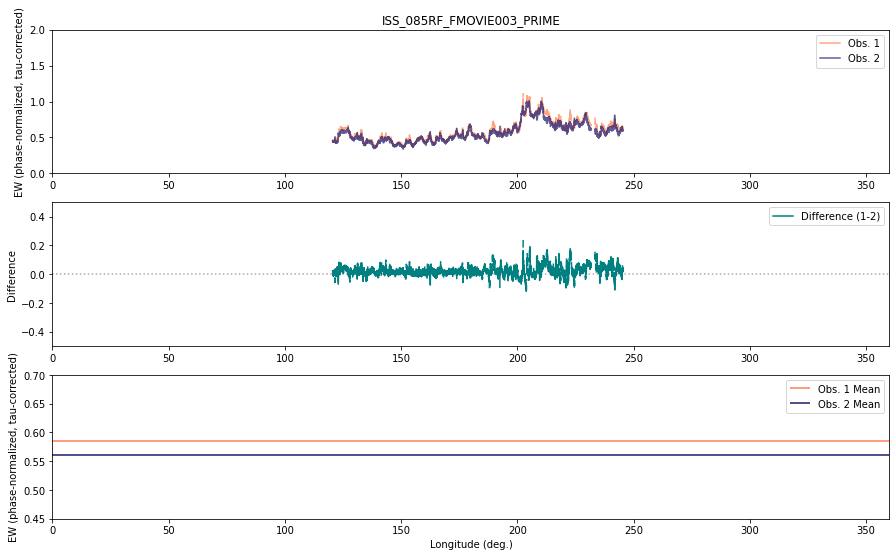

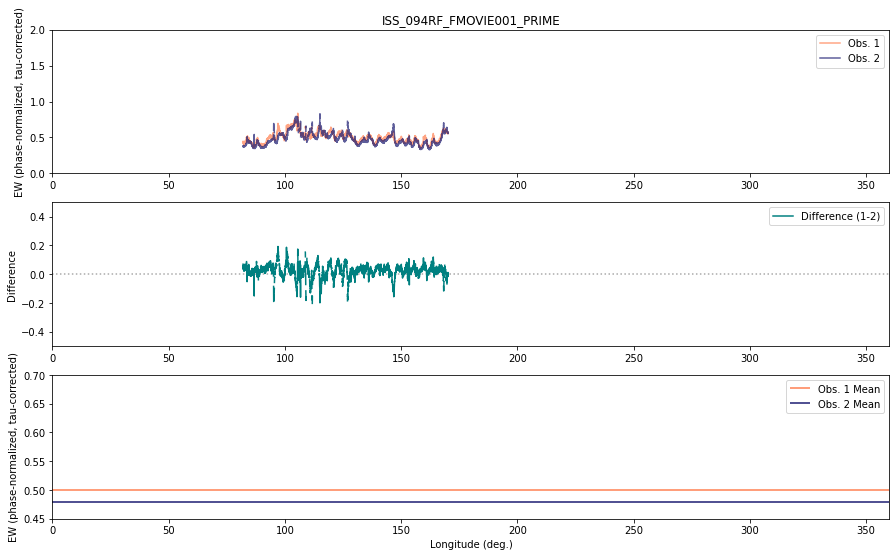

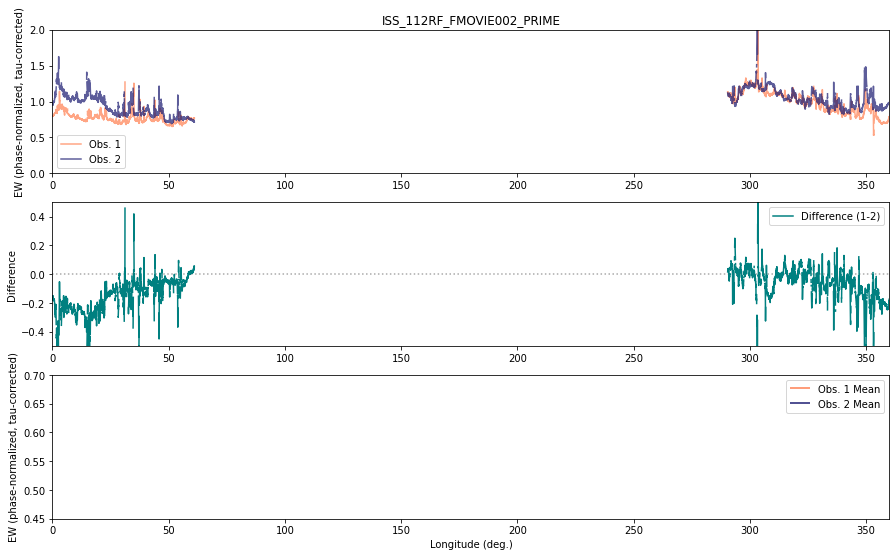

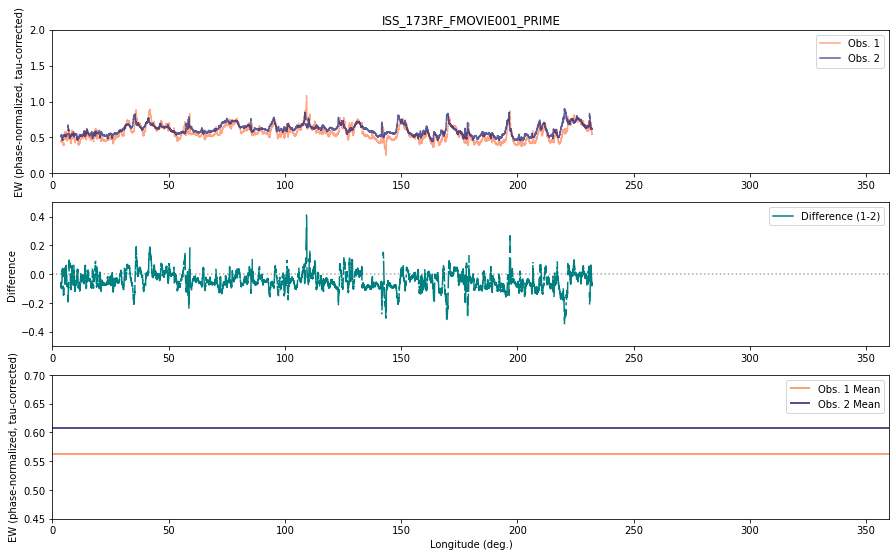

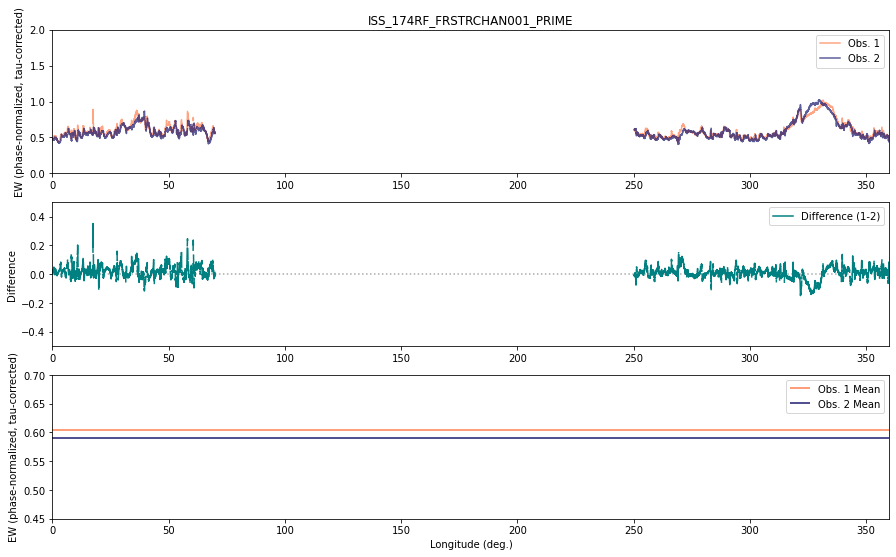

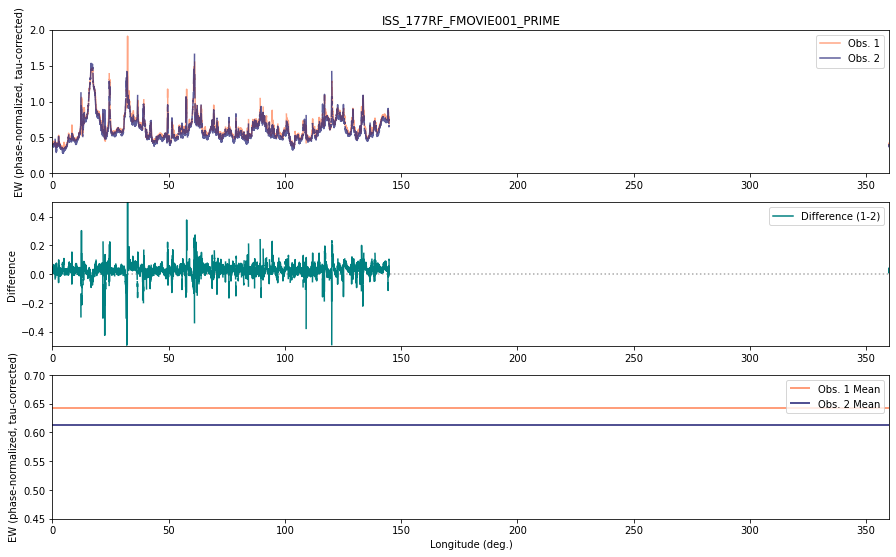

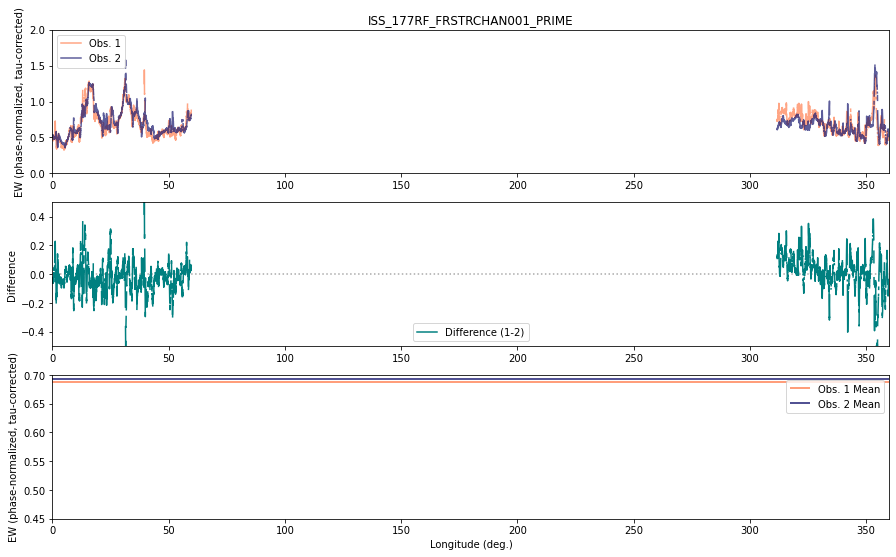

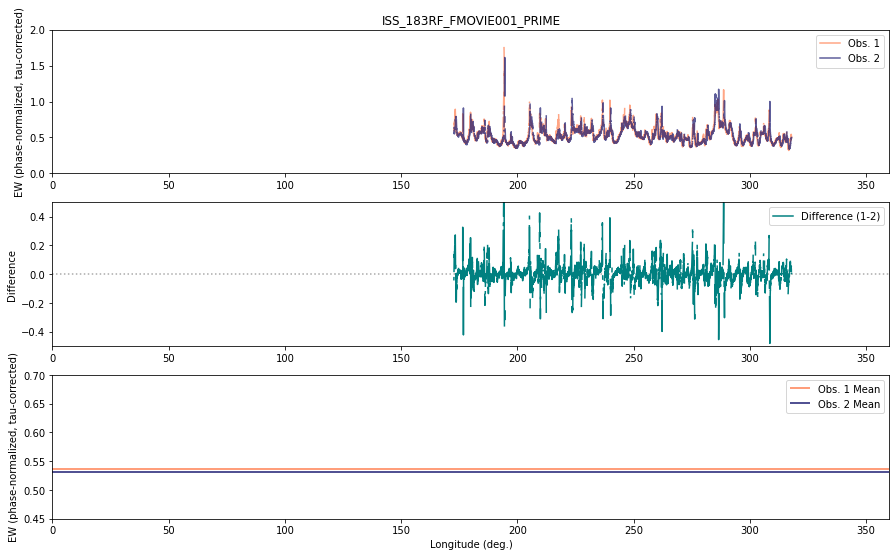

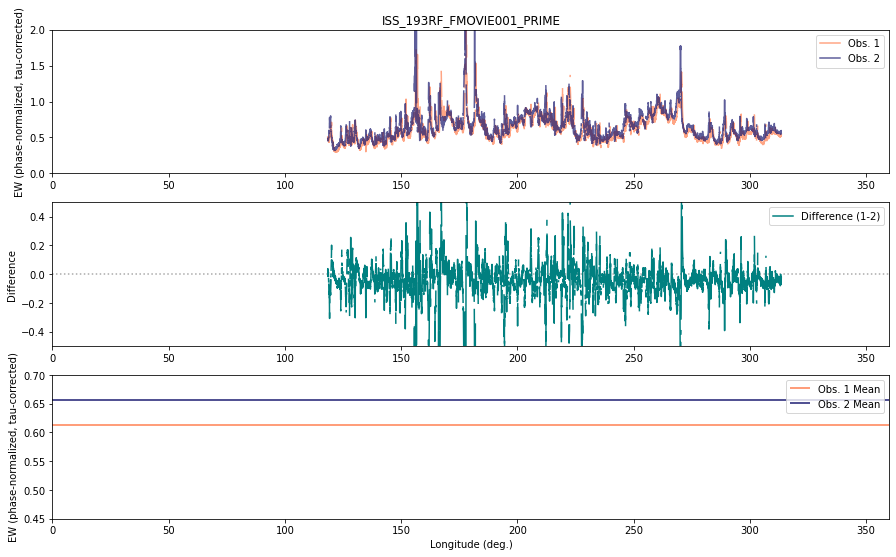

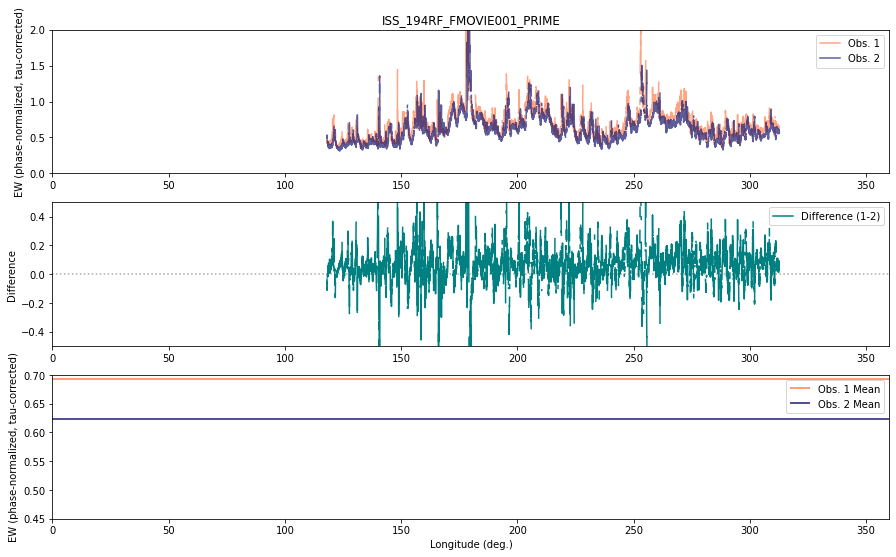

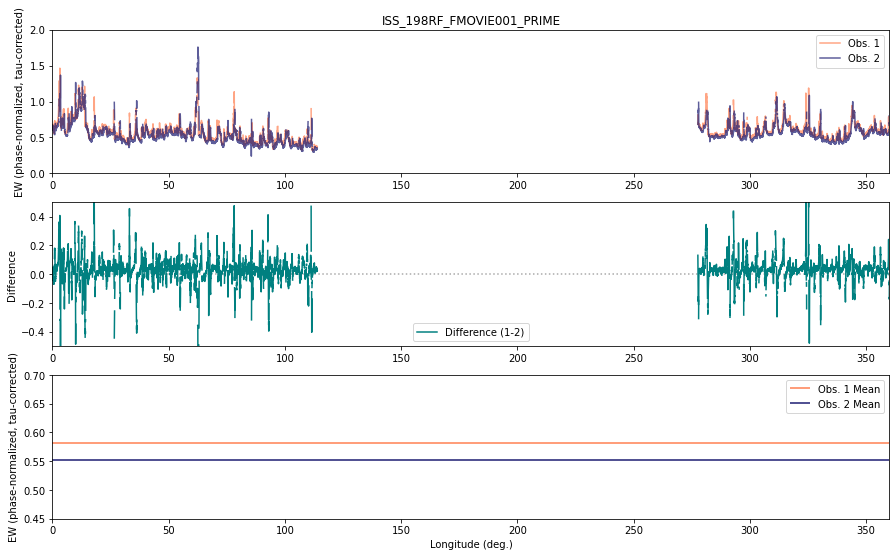

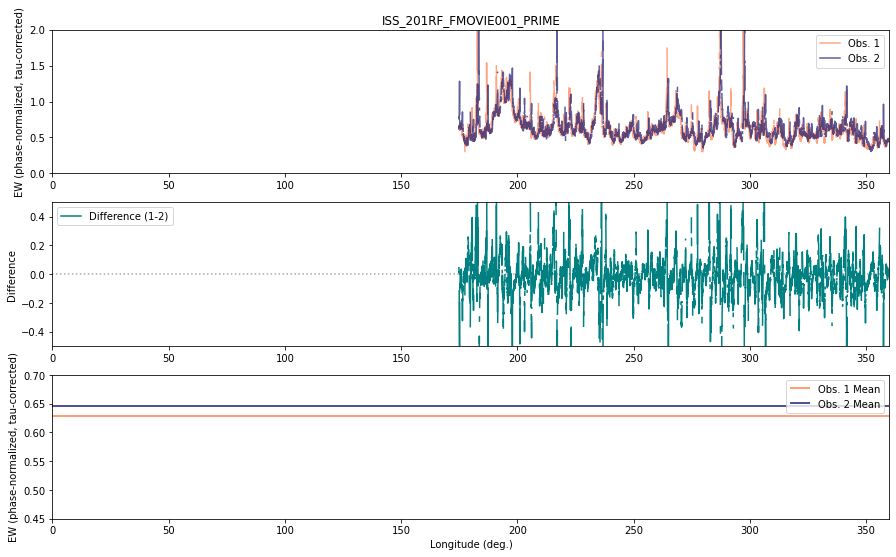

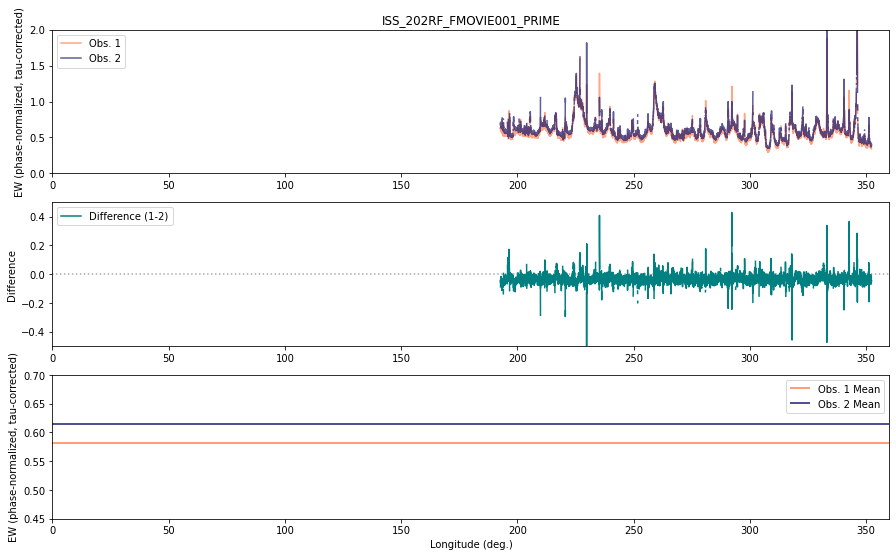

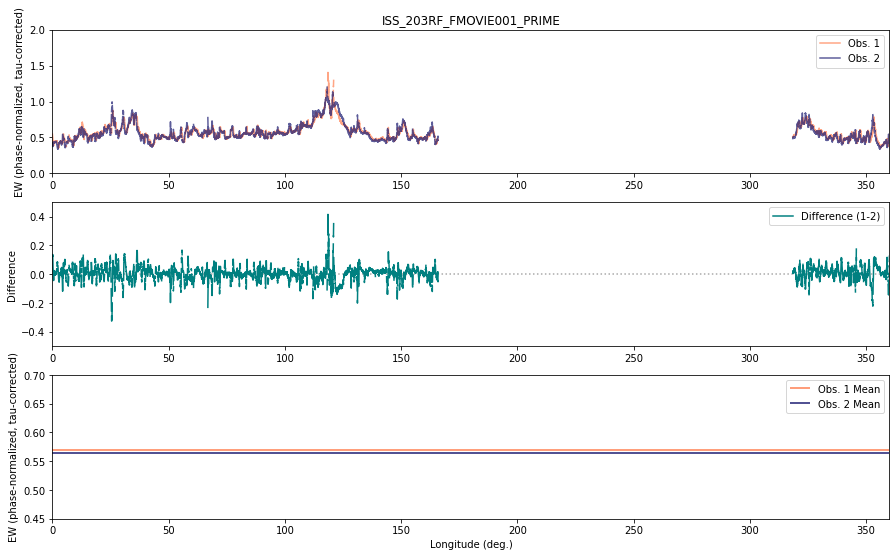

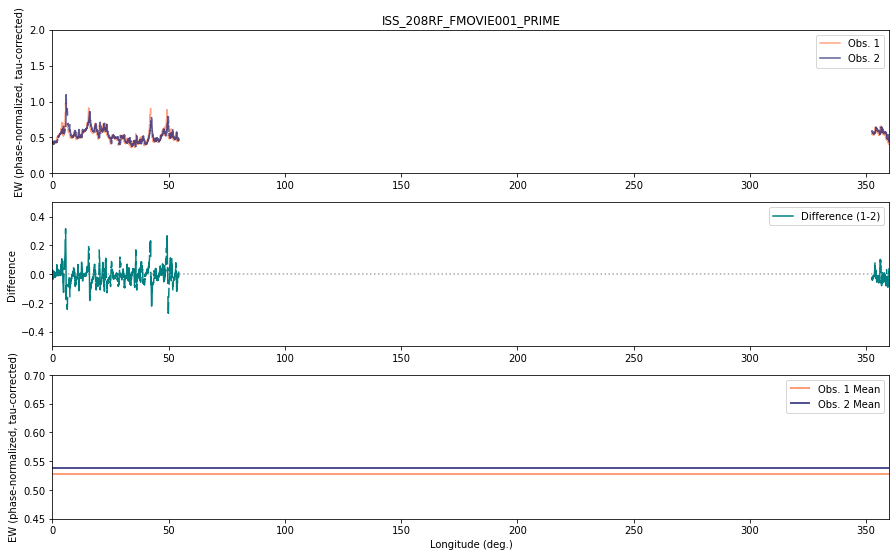

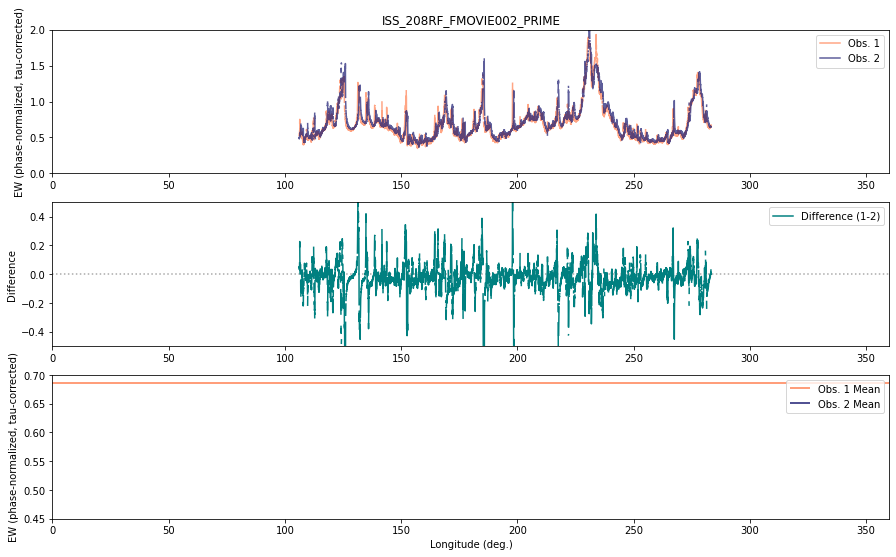

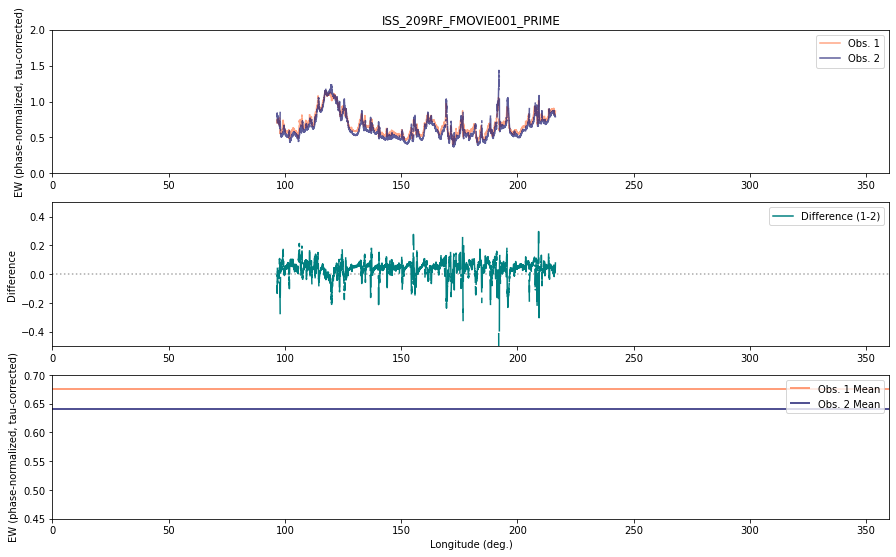

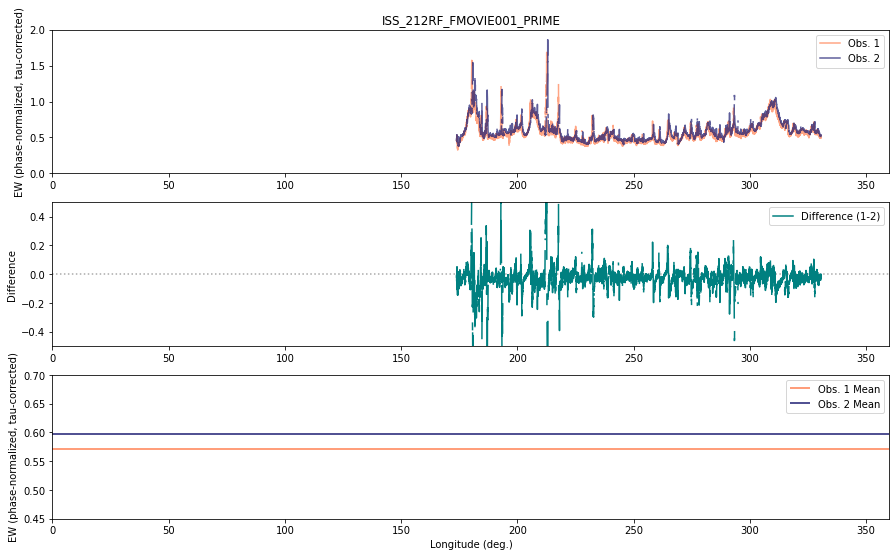

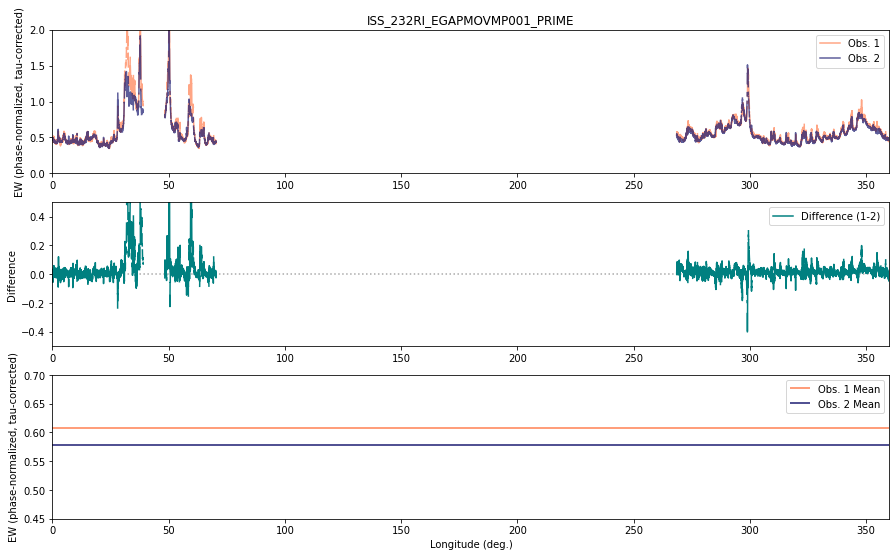

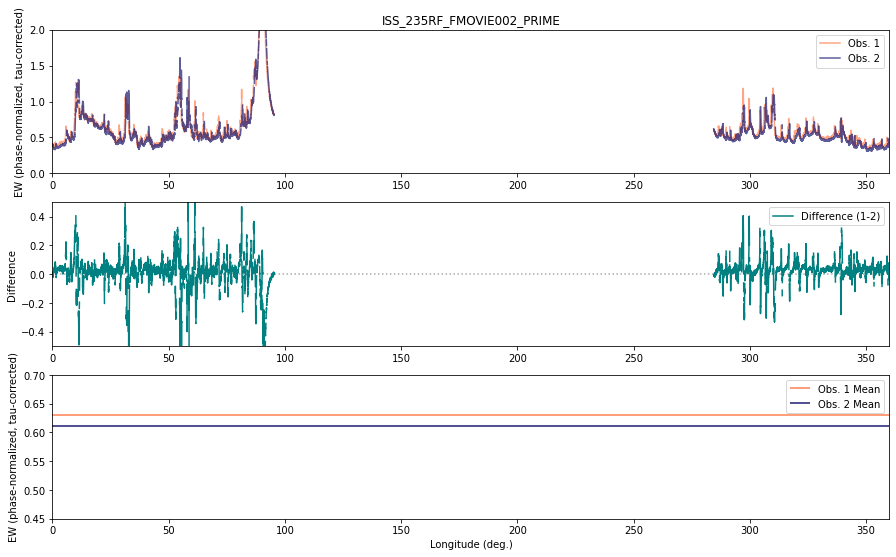

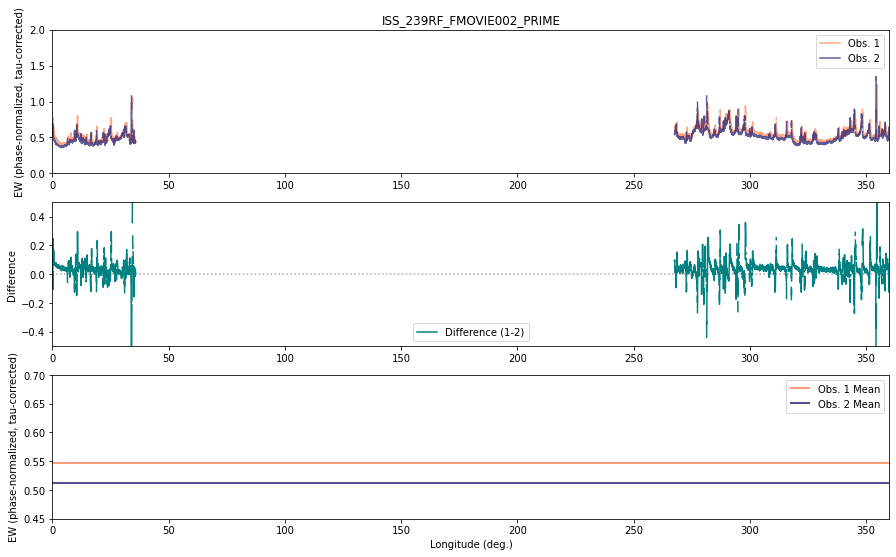

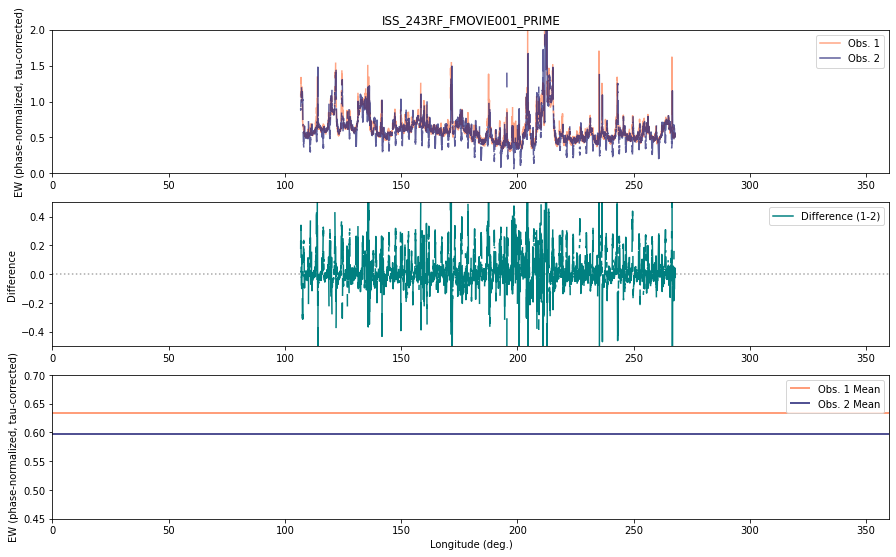

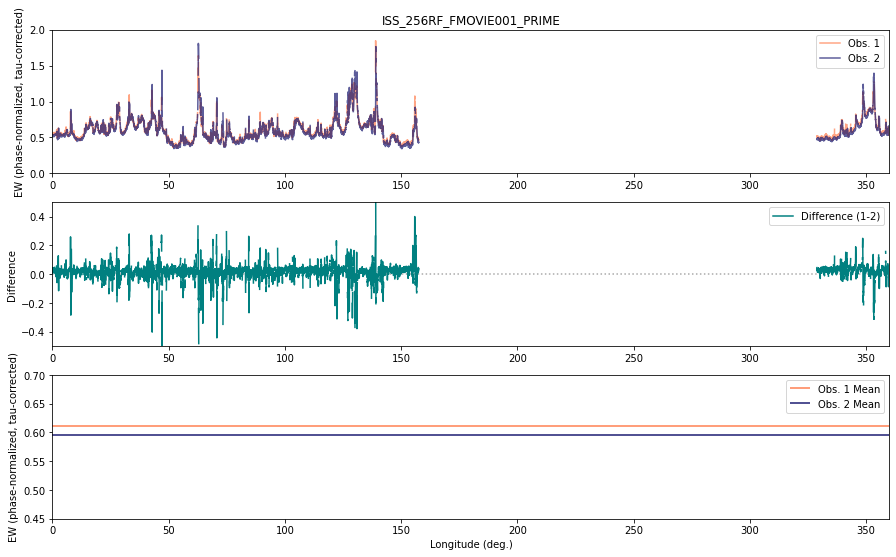

In [9]:
# Overplot the EW profiles (tau-adjusted, phase-normalized) of each observation pair
#bases = ['ISS_085RF_FMOVIE003_PRIME']
all_longitudes = np.arange(0,360+size,size)
all_longitudes = pd.DataFrame(all_longitudes, columns=['Min Long'])

for base in bases:
    #separate out just the data for that pair of observations
    base_obsdata = obsdata.loc[base]
    
    #add NaN values for degrees without data
    blanked_obsdata = all_longitudes.merge(base_obsdata, how='left', on=['Min Long'])
    
    longitudes = blanked_obsdata['Min Long'] #does not have a suffix since it was the col being joined on
    norm_ews_1 = blanked_obsdata['Normal EW3ZPN_1']
    norm_ews_2 = blanked_obsdata['Normal EW3ZPN_2']
    
    plt.figure(figsize=(15,9))
    plt.subplot(3, 1, 1)
    plt.plot(longitudes, norm_ews_1, label='Obs. 1', c='coral', alpha=0.7)
    plt.plot(longitudes, norm_ews_2, label='Obs. 2', c='midnightblue', alpha=0.7)
    plt.ylabel('EW (phase-normalized, tau-corrected)')
    plt.ylim(0,2)
    plt.xlim(0,360)
    
    plt.title(f'{base}')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.hlines([0], xmin=0, xmax=360, ls='dotted', colors=['darkgray'])
    plt.plot(longitudes, norm_ews_1 - norm_ews_2, label='Difference (1-2)', c='teal')
    plt.ylabel('Difference')
    plt.ylim(-0.5,0.5)
    plt.xlim(0,360)
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.hlines([np.mean(norm_ews_1)], xmin=0, xmax=360, label='Obs. 1 Mean', colors=['coral'])
    plt.hlines([np.mean(norm_ews_2)], xmin=0, xmax=360, label='Obs. 2 Mean', colors=['midnightblue'])
    plt.ylabel('EW (phase-normalized, tau-corrected)')
    plt.xlabel('Longitude (deg.)')
    plt.ylim(0.45, 0.7)
    plt.xlim(0,360)
    plt.legend()
    
    plt.savefig(save_ew_dir+f'{base}_ew_profile.png', bbox_inches='tight')
    
    plt.show()

In [10]:
# plot the differences between the EW profiles
# also then plot the difference between the 2D images/mosaics, then save those
# just multiply by the HG function value for that longitude's phase angle, then divide by HG function at phase 0
# or could just try by dividing by image's mean or median

# go through and compute the EW, but *only* for the common longitudes (e.g. 1 point for the whole plot)
# but only the common longitudes
# then compare them, phase-normalized

# Plot subtracted _1/_2 mosaics

/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_80776/1404296924.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(15,4))


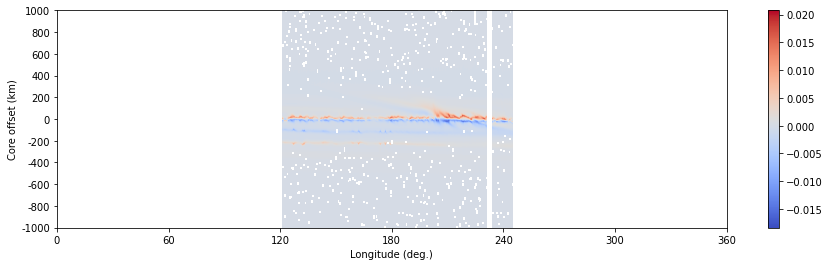

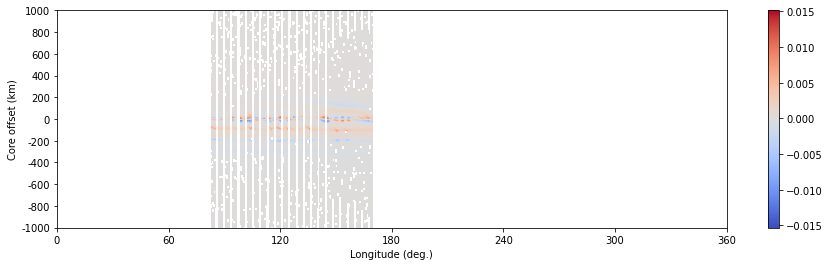

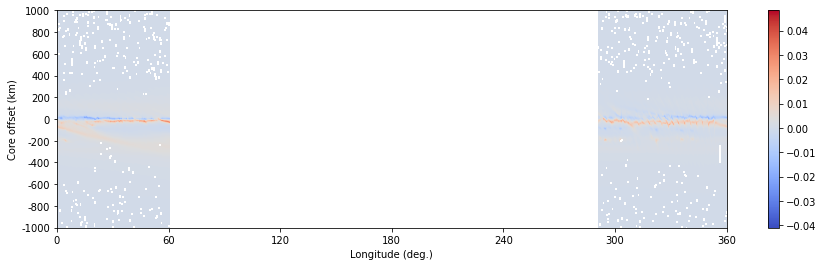

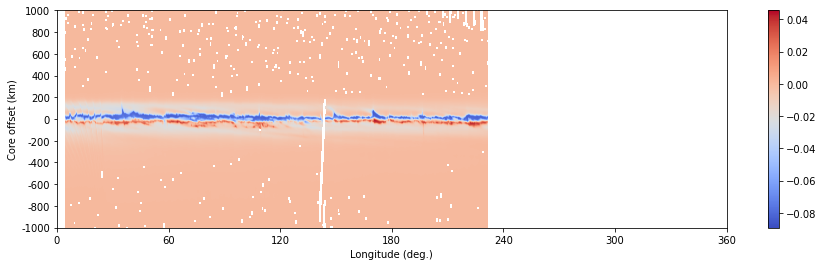

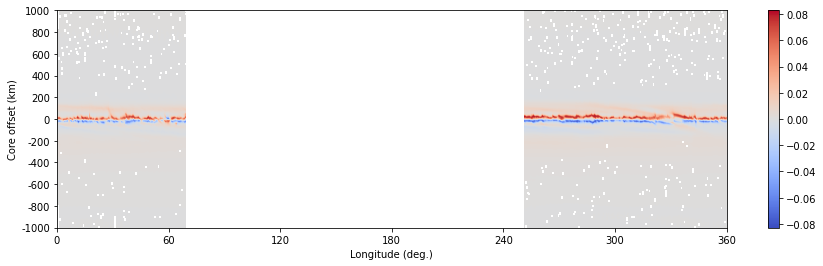

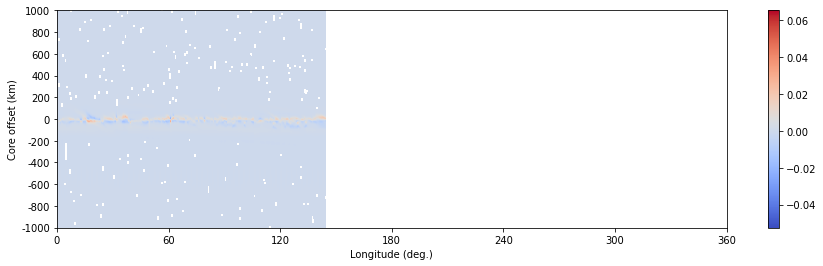

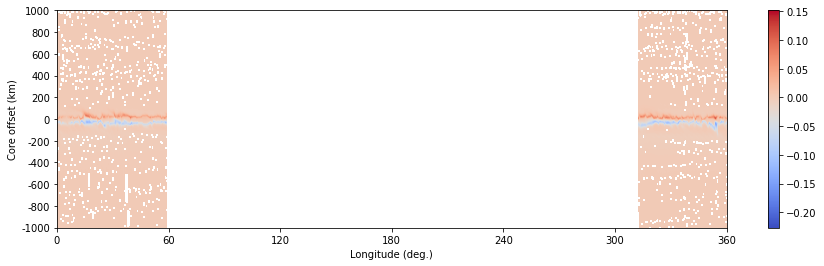

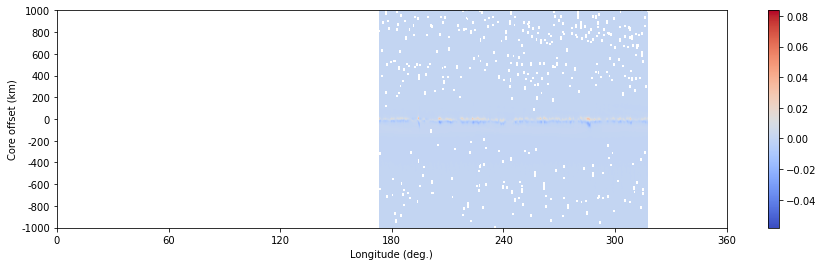

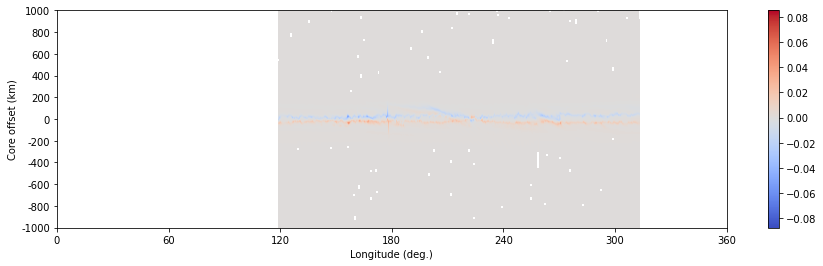

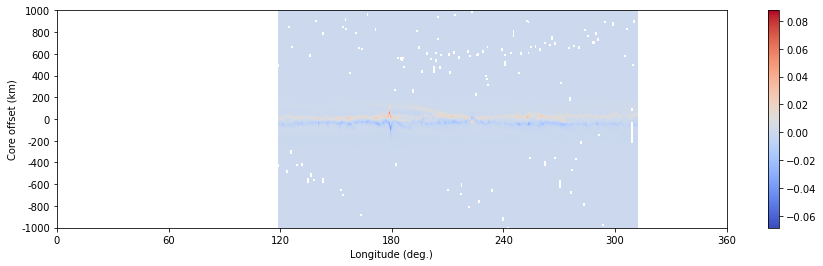

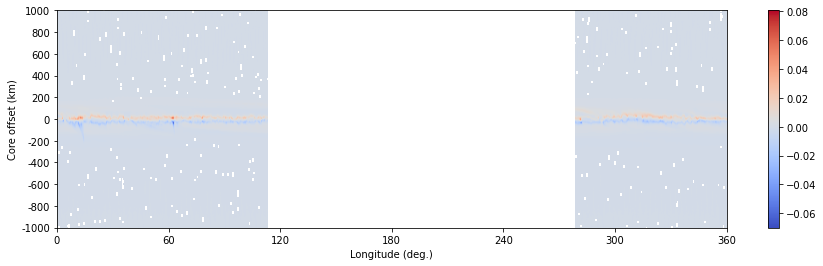

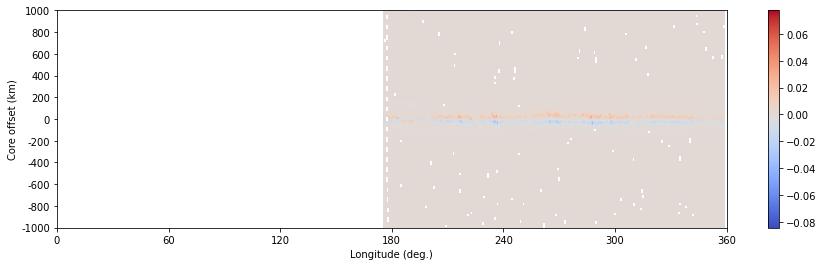

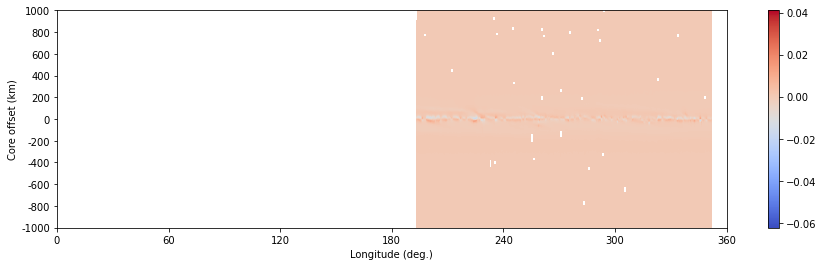

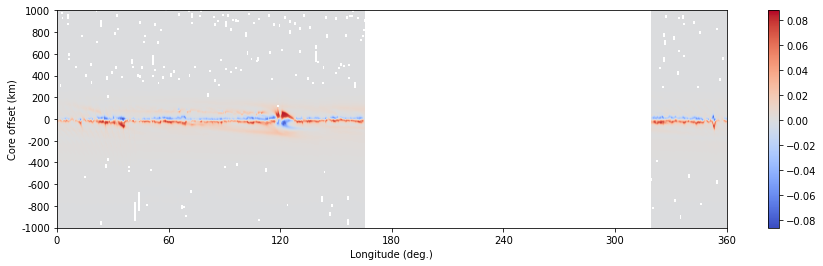

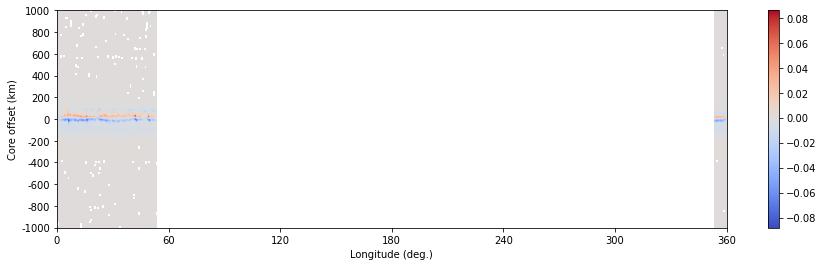

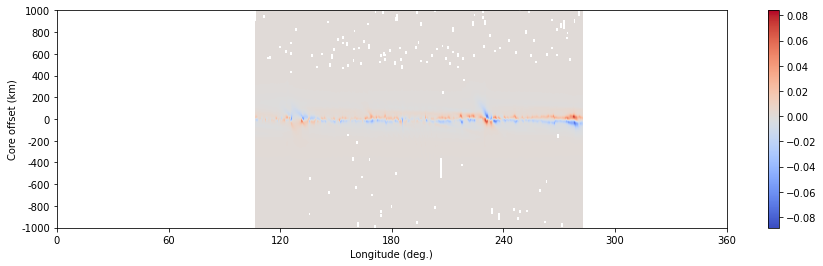

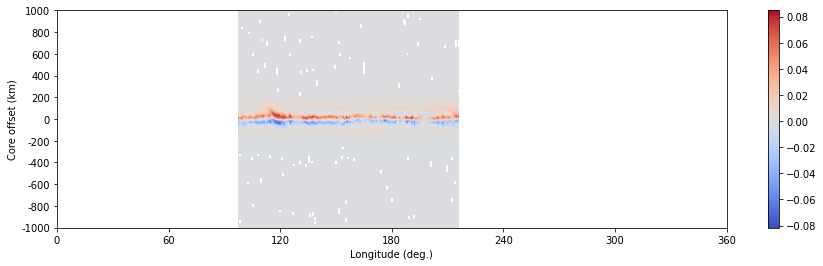

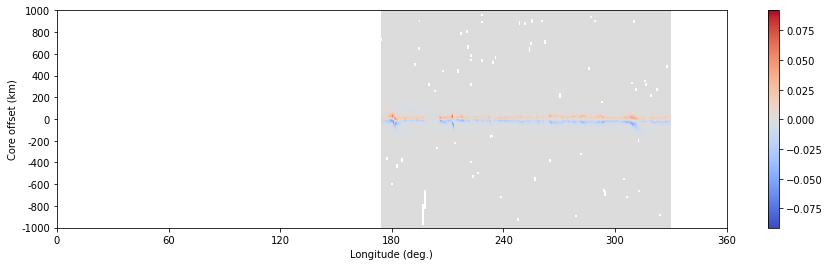

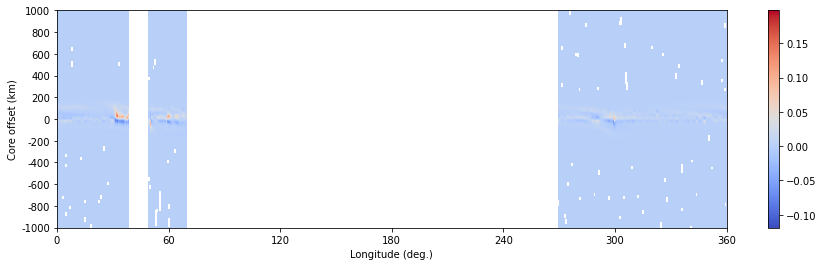

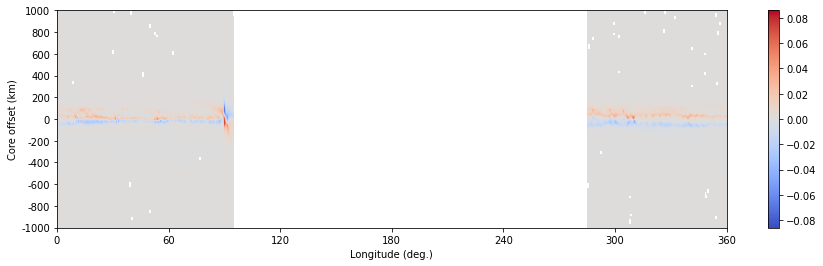

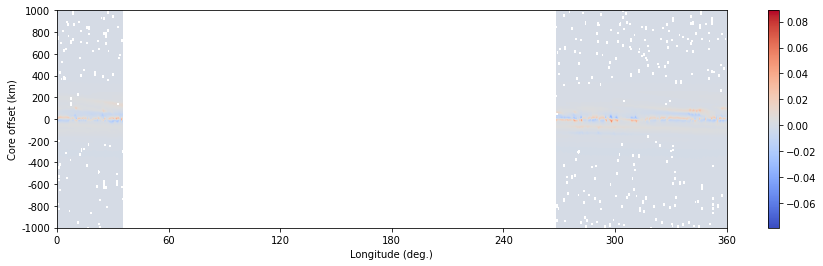

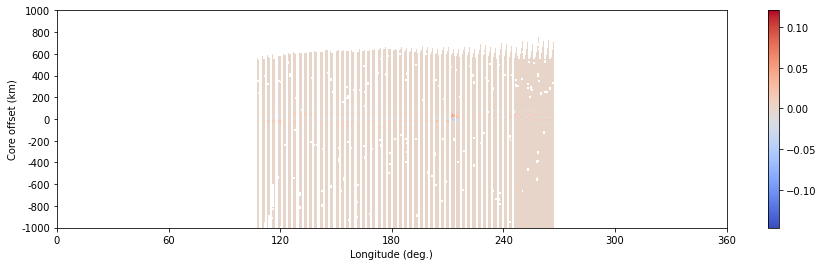

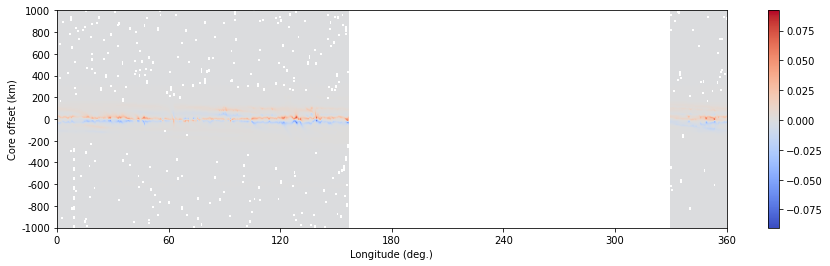

In [11]:
# Plot subtracted _1/_2 mosaics (normalized)
# multiply by the HG function value for that longitude's phase angle, then divide by HG function at phase 0

res = 0.02 #degress longitude per pixel
rad1= 139220
rad2= 141220

#hard-code argparse namespace object (to be able to load mosaics on Jupyter notebook)
arguments = Namespace(voyager=False, ew_inner_radius=None, ew_outer_radius=None, obsid=[[]],\
                      ring_type='FMOVIE', corot_type='', start_obsid='', end_obsid='', ring_radius=140220, \
                      radius_inner_delta=-1000, radius_outer_delta=1000, radius_resolution=5.0, \
                      longitude_resolution=0.02, radial_zoom_amount=10, longitude_zoom_amount=1, verbose=False)

for base in bases:
    
    normalized_mosaics = []
    #load in each mosaic in the pair separately, append to list for the moment
    for i in range(1,3):
        obs_id = base+f'_{i}'
        
        (bkgnd_sub_mosaic_filename, bkgnd_sub_mosaic_metadata_filename) = bkgnd_sub_mosaic_paths(arguments, obs_id)

        if (not os.path.exists(bkgnd_sub_mosaic_filename) or
            not os.path.exists(bkgnd_sub_mosaic_metadata_filename)):
            print('NO FILE', bkgnd_sub_mosaic_filename,
                  'OR', bkgnd_sub_mosaic_metadata_filename)
            continue

        with open(bkgnd_sub_mosaic_metadata_filename, 'rb') as bkgnd_metadata_fp:
            metadata = pickle.load(bkgnd_metadata_fp, encoding='latin1')
        with np.load(bkgnd_sub_mosaic_filename) as npz:
            mosaic_img = ma.MaskedArray(**npz)
        
        #process the mosaic (get HG param value for each longitude/column)
        #multiply each column by HG function value for that column's phase angle
        #then divide column by HG function at phase 0
        
        phase_angles = metadata['phase_angles']
        hg_vals = np.array([hg_func(hg_params, xpts=phase) for phase in phase_angles])
        hg_0_val = hg_func(hg_params, xpts=0)
        
        for col in range(mosaic_img.shape[1]):
            mosaic_img[:,col] = mosaic_img[:,col]*hg_vals[col]
            mosaic_img[:,col] = mosaic_img[:,col]/hg_0_val
            
        #print(obs_id+' done')    
        
        #save processed mosaic to list
        normalized_mosaics.append(mosaic_img)
    
    #subtract the two mosaics from each other (1-2)
    subtracted_mosaic = normalized_mosaics[0] - normalized_mosaics[1]
    
    #plot the image, save
    fig, ax = plt.subplots(1, 1, figsize=(15,4))
    cmap = plt.cm.get_cmap('viridis').copy()
    cmap.set_bad(color='black', alpha = 1.)
    img = ax.imshow(subtracted_mosaic, cmap='coolwarm', aspect='auto', origin='lower') #, vmin=-0.15, vmax=0.15)

    x_labels = [r for r in range(0,360+1,60)]
    y_labels = [(r-140220) for r in range(rad1,rad2+1,200)]
    plt.xticks(ticks=np.linspace(0, 360/res, 7), labels=x_labels)
    plt.yticks(ticks=np.linspace(0, subtracted_mosaic.shape[0], len(y_labels)), labels=y_labels)
    plt.xlabel('Longitude (deg.)')
    plt.ylabel('Core offset (km)')
    
    plt.colorbar(img)

    plt.savefig(save_mosaics_dir+f'{base}_subtracted_mosaic.png', bbox_inches='tight')

/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_80776/3537704199.py:79: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(img)
/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_80776/3537704199.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots(1, 1, figsize=(15,4))


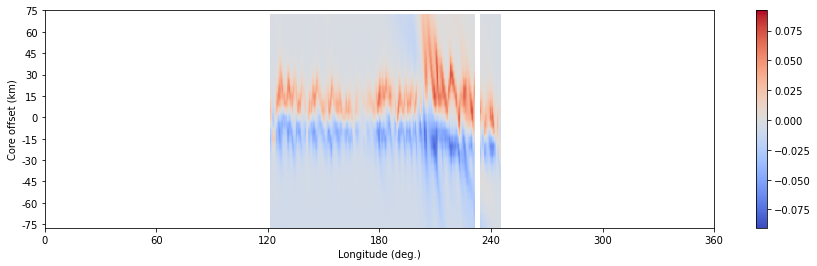

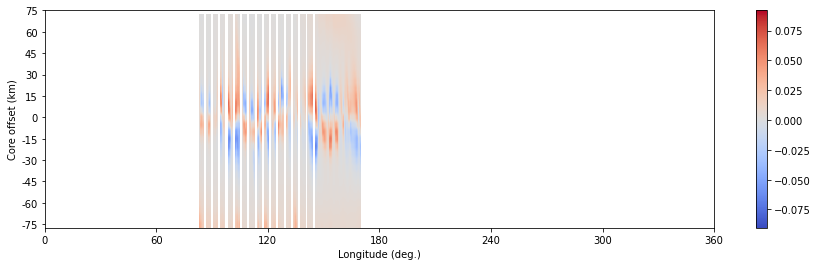

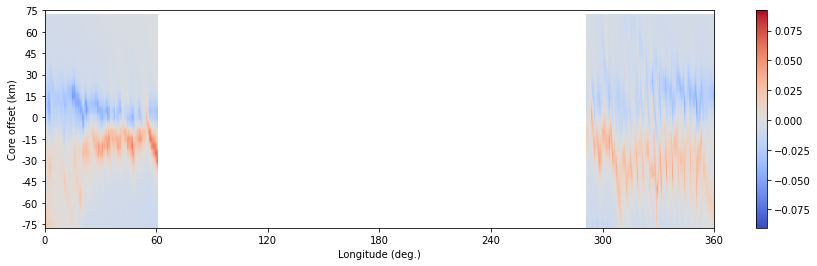

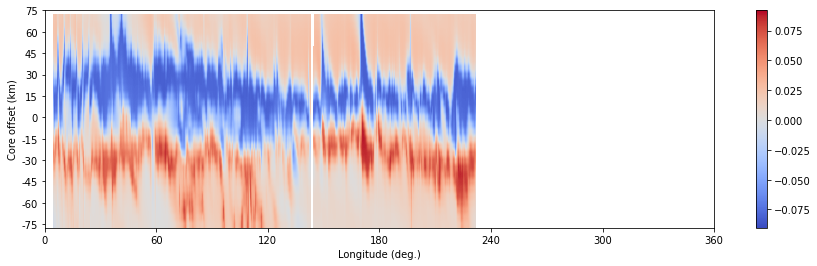

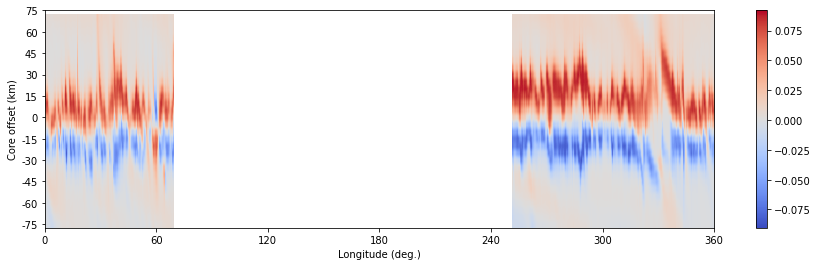

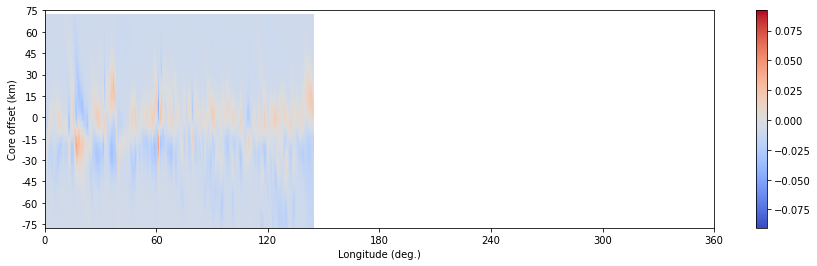

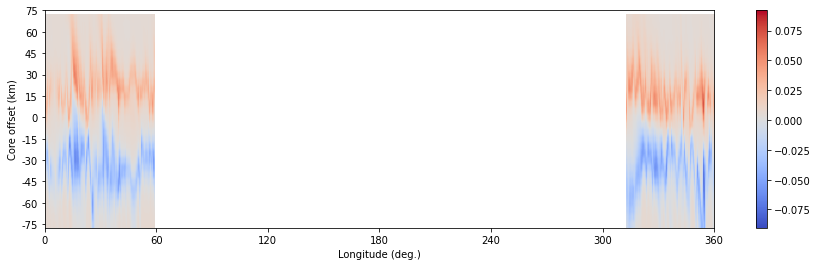

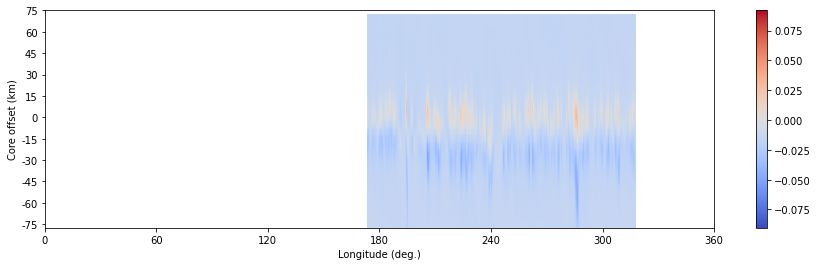

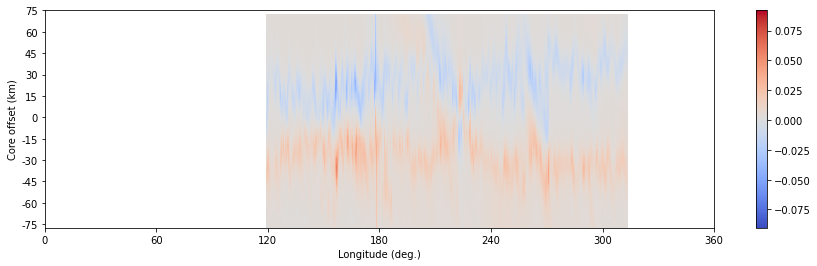

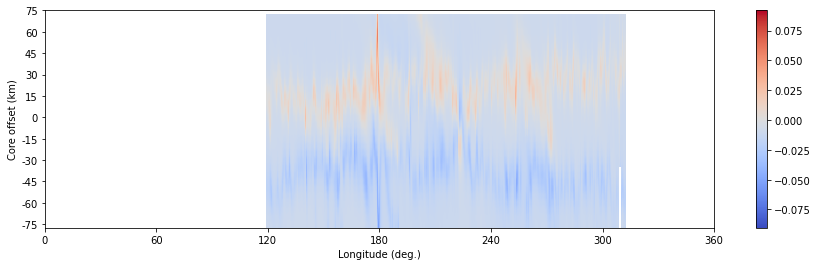

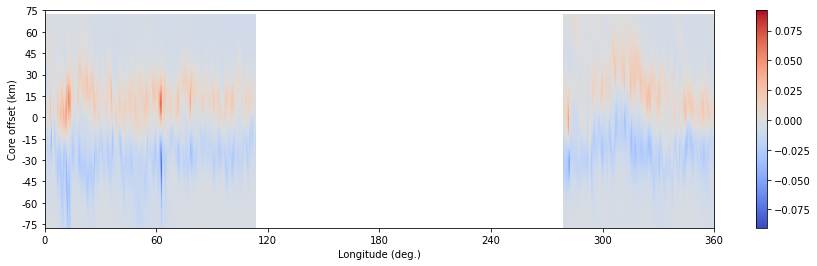

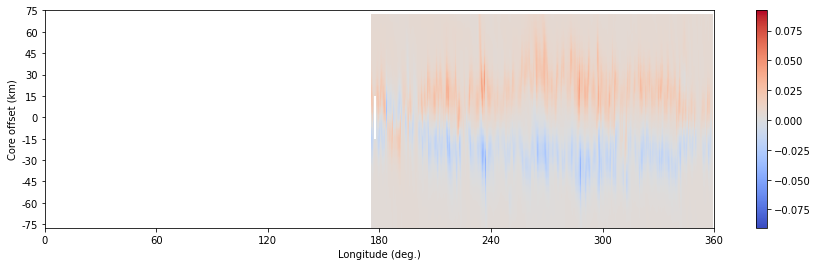

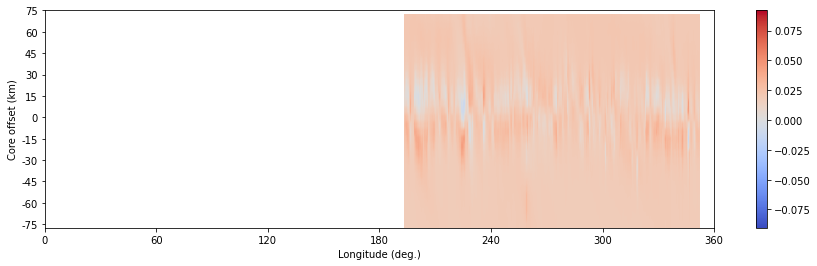

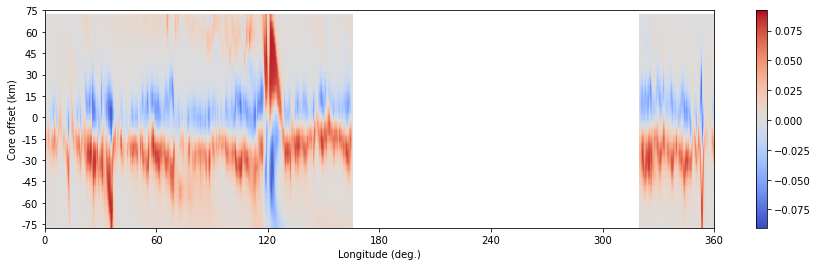

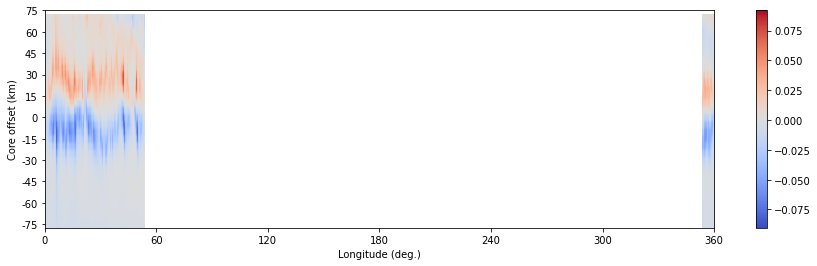

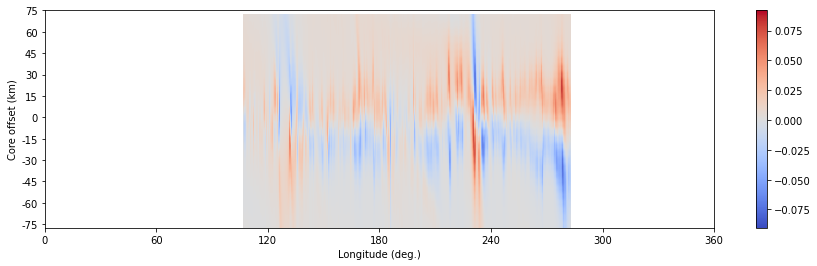

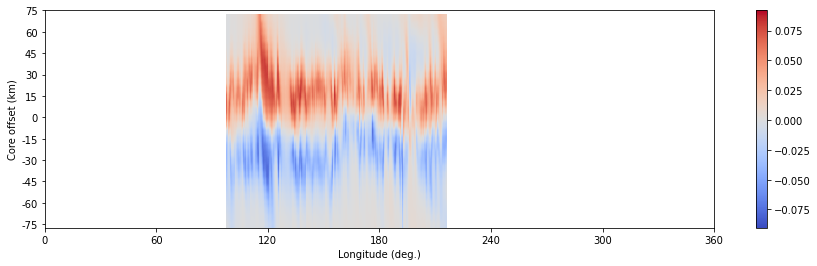

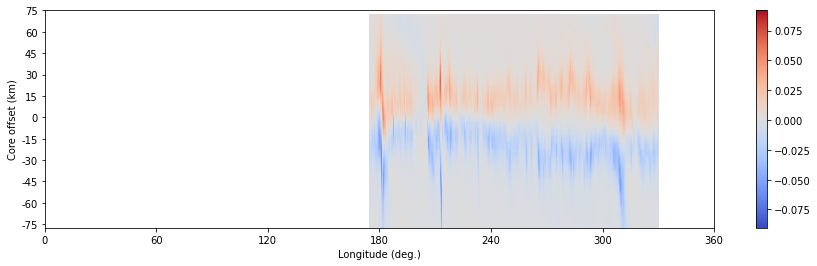

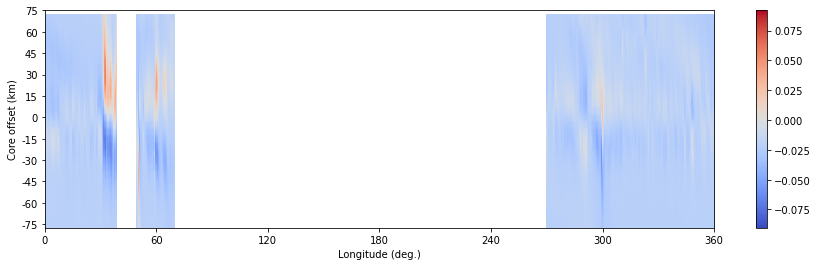

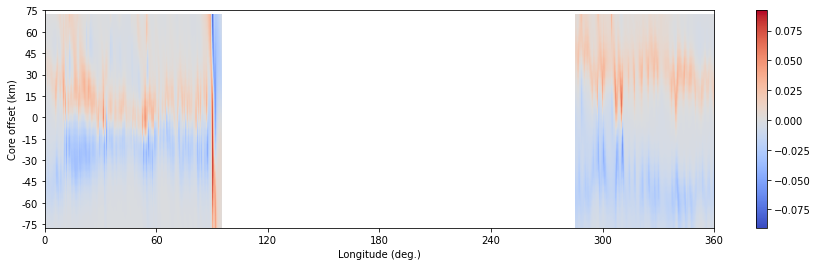

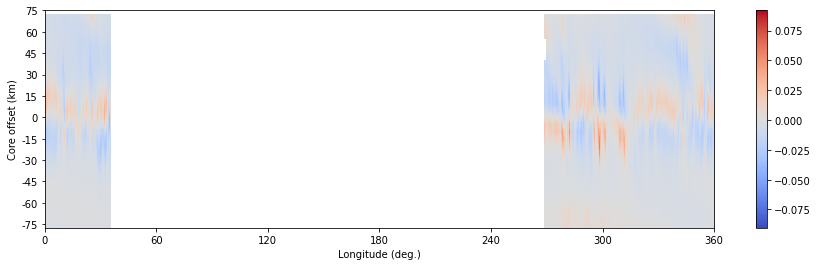

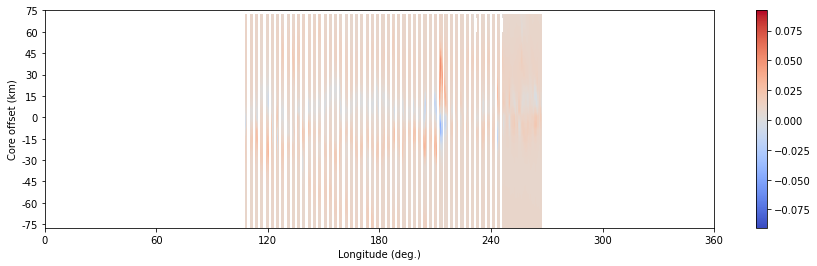

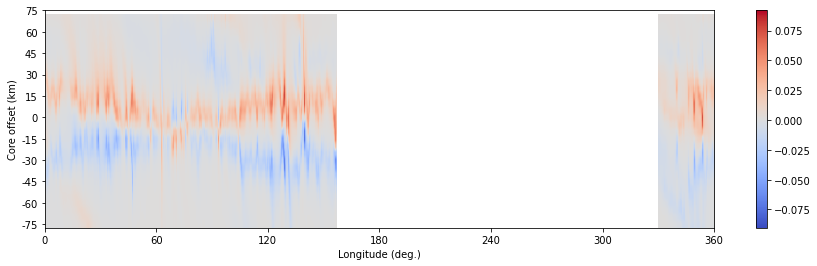

In [12]:
# plot cropped version of mosaic (zoomed-in vertically on the core)
# Plot subtracted _1/_2 mosaics (normalized)
# multiply by the HG function value for that longitude's phase angle, then divide by HG function at phase 0

#400 pixels vertically for a 2000 km-wide strip
#5 km per pixel vertically

res = 0.02 #degress longitude per pixel
#define cropping longitudes (deg.) (do +/- 200 km)
lon1 = 0
lon2 = 360
rad1= 140145
rad2= 140295

#hard-code argparse namespace object (to be able to load mosaics on Jupyter notebook)
arguments = Namespace(voyager=False, ew_inner_radius=None, ew_outer_radius=None, obsid=[[]],\
                      ring_type='FMOVIE', corot_type='', start_obsid='', end_obsid='', ring_radius=140220, \
                      radius_inner_delta=-1000, radius_outer_delta=1000, radius_resolution=5.0, \
                      longitude_resolution=0.02, radial_zoom_amount=10, longitude_zoom_amount=1, verbose=False)

for base in bases:
    
    normalized_mosaics = []
    #load in each mosaic in the pair separately, append to list for the moment
    for i in range(1,3):
        obs_id = base+f'_{i}'
        
        (bkgnd_sub_mosaic_filename, bkgnd_sub_mosaic_metadata_filename) = bkgnd_sub_mosaic_paths(arguments, obs_id)

        if (not os.path.exists(bkgnd_sub_mosaic_filename) or
            not os.path.exists(bkgnd_sub_mosaic_metadata_filename)):
            print('NO FILE', bkgnd_sub_mosaic_filename,
                  'OR', bkgnd_sub_mosaic_metadata_filename)
            continue

        with open(bkgnd_sub_mosaic_metadata_filename, 'rb') as bkgnd_metadata_fp:
            metadata = pickle.load(bkgnd_metadata_fp, encoding='latin1')
        with np.load(bkgnd_sub_mosaic_filename) as npz:
            mosaic_img = ma.MaskedArray(**npz)
        
        #process the mosaic (get HG param value for each longitude/column)
        #multiply each column by HG function value for that column's phase angle
        #then divide column by HG function at phase 0
        #print(obs_id+' done')
        #take cropped, sampled section of full (401,18000 mosaic)
        #want (80 pixels high, 2500 pixels across) (400 km x 50 deg. longitude)
        #(keeping full extent of 360 longitude for this one)
        #cropped_mosaic = mosaic_img[150:250, :]
        cropped_mosaic = mosaic_img[int((rad1-139220)/5):int((rad2-139220)/5), :]
        #print(mosaic_img.shape)

        #normalize the cropped mosaic before appending to list
        phase_angles = metadata['phase_angles']
        hg_vals = np.array([hg_func(hg_params, xpts=phase) for phase in phase_angles])
        hg_0_val = hg_func(hg_params, xpts=0)
        #multiply each column of mosaic by hg value
        for col in range(cropped_mosaic.shape[1]):
            cropped_mosaic[:,col] = cropped_mosaic[:,col]*hg_vals[col]
        #divide each value of mosaic by hg value at 0
        cropped_mosaic = cropped_mosaic/hg_0_val
        
        #save processed mosaic to list
        normalized_mosaics.append(cropped_mosaic)
    
    #subtract the two mosaics from each other (1-2)
    subtracted_mosaic = normalized_mosaics[0] - normalized_mosaics[1]
    
    #plot the image, save
    fig2, ax2 = plt.subplots(1, 1, figsize=(15,4))
    img2 = ax2.imshow(subtracted_mosaic, cmap='coolwarm', aspect='auto', origin='lower') #, vmin=-0.15, vmax=0.15)

    x_labels = [r for r in range(0,360+1,60)]
    y_labels = [(r-140220) for r in range(rad1,rad2+1,15)]
    plt.xticks(ticks=np.linspace(0, 360/res, 7), labels=x_labels)
    plt.yticks(ticks=np.linspace(0, subtracted_mosaic.shape[0], len(y_labels)), labels=y_labels)
    plt.xlabel('Longitude (deg.)')
    plt.ylabel('Core offset (km)')
    
    plt.colorbar(img)

    plt.savefig(save_mosaics_dir_cropped+f'{base}_subtracted_mosaic.png', bbox_inches='tight')
        
        
        

In [13]:
for base in bases:
    #separate out just the data for that pair of observations
    base_obsdata = obsdata.loc[base]
    print(base_obsdata[['Date_1', 'Date_2']].iloc[0])
    print()

Date_1   2008-09-16 04:17:03
Date_2   2008-09-16 11:37:03
Name: ISS_085RF_FMOVIE003_PRIME, dtype: datetime64[ns]

Date_1   2008-11-22 00:59:11
Date_2   2008-11-22 08:19:11
Name: ISS_094RF_FMOVIE001_PRIME, dtype: datetime64[ns]

Date_1   2009-06-10 14:29:50
Date_2   2009-06-10 21:41:18
Name: ISS_112RF_FMOVIE002_PRIME, dtype: datetime64[ns]

Date_1   2012-10-16 03:41:49
Date_2   2012-10-16 11:44:29
Name: ISS_173RF_FMOVIE001_PRIME, dtype: datetime64[ns]

Date_1   2012-11-09 00:51:09
Date_2   2012-11-09 08:02:37
Name: ISS_174RF_FRSTRCHAN001_PRIME, dtype: datetime64[ns]

Date_1   2012-12-19 02:22:53
Date_2   2012-12-19 08:18:37
Name: ISS_177RF_FMOVIE001_PRIME, dtype: datetime64[ns]

Date_1   2012-12-25 04:55:57
Date_2   2012-12-25 11:46:37
Name: ISS_177RF_FRSTRCHAN001_PRIME, dtype: datetime64[ns]

Date_1   2013-03-05 04:09:01
Date_2   2013-03-05 10:09:01
Name: ISS_183RF_FMOVIE001_PRIME, dtype: datetime64[ns]

Date_1   2013-06-20 06:50:05
Date_2   2013-06-20 14:47:57
Name: ISS_193RF_FMOVIE00

# Plot median-stacked mosaic

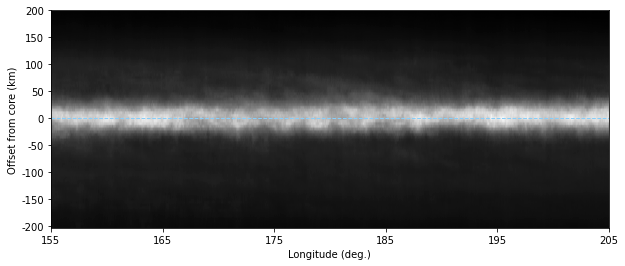

In [14]:
# Plot mosaics all stacked together, taking median of the stack

#define cropping longitudes (deg.)
lon1 = 155
lon2 = 205
#define cropping radii (core at center, 1000km into image) (km.)
rad1 = 800
rad2 = 1200

array_list = []

i = 0
for obs_id in enumerate_obsids(arguments):
    (bkgnd_sub_mosaic_filename, bkgnd_sub_mosaic_metadata_filename) = bkgnd_sub_mosaic_paths(arguments, obs_id)

    if (not os.path.exists(bkgnd_sub_mosaic_filename) or
        not os.path.exists(bkgnd_sub_mosaic_metadata_filename)):
        print('NO FILE', bkgnd_sub_mosaic_filename,
              'OR', bkgnd_sub_mosaic_metadata_filename)
        continue

    with open(bkgnd_sub_mosaic_metadata_filename, 'rb') as bkgnd_metadata_fp:
        metadata = pickle.load(bkgnd_metadata_fp, encoding='latin1')
    with np.load(bkgnd_sub_mosaic_filename) as npz:
        bkgnd_sub_mosaic_img = ma.MaskedArray(**npz)

    #print(obs_id+' done')
    #take cropped, sampled section of full (401,18000 mosaic)
    #want (80 pixels high, 2500 pixels across) (400 km x 50 deg. longitude)
    cropped_mosaic = bkgnd_sub_mosaic_img[int(rad1/5):int(rad2/5), int(lon1*50):int(lon2*50)]


    #normalize the cropped mosaic before appending to list
    #get out + crop phase angle values + DON'T convert to degrees (automatically in radians)
    cropped_phase_angles = metadata['phase_angles'][int(lon1*50):int(lon2*50)]
    #cropped_phase_angles = np.degrees(metadata['phase_angles'][int(lon1*50):int(lon2*50)])
    #find the H-G func values at each pixel (km)
    cropped_hg_vals = np.array([hg_func(hg_params, xpts=phase) for phase in cropped_phase_angles])
    #multiple each column of mosaic by hg value
    for col in range(cropped_mosaic.shape[1]):
        cropped_mosaic[:,col] = cropped_mosaic[:,col]*cropped_hg_vals[col]
    #divide each value of mosaic by hg value at 0
    cropped_mosaic = cropped_mosaic/hg_0_val


    #append normalized mosaic to list
    array_list.append(cropped_mosaic)

    #if i == 0:
    #    break

    i+=1

#stack mosaics and take median along stacked axis
stacked_mosaic = np.ma.dstack(array_list)
median_mosaic = np.ma.median(stacked_mosaic, axis=2)


#save as image
fig, ax = plt.subplots(1, 1, figsize=(10,4))
img = ax.imshow(median_mosaic, cmap='Greys_r', aspect='auto', origin='lower')

x_labels = [r for r in range(lon1,lon2+1,10)]
y_labels = [r for r in range(rad1-1000,rad2-1000+1,50)]
plt.xticks(ticks=np.linspace(0, ((lon2*50)-(lon1*50)), 6), labels=x_labels)
plt.yticks(ticks=np.linspace(0, 80, 9), labels=y_labels)
plt.xlabel('Longitude (deg.)')
plt.ylabel('Offset from core (km)')

plt.axhline(y=40, color='lightskyblue', linestyle='--', lw=1) #uses axes y, not img

plt.show()

In [15]:
print(obsdata.columns)

Index(['Slice#_1', 'Num Data_1', 'Date_1', 'Min Long', 'Max Long_1',
       'Min Res_1', 'Max Res_1', 'Mean Res_1', 'Min Phase_1', 'Max Phase_1',
       'Mean Phase_1', 'Min Emission_1', 'Max Emission_1', 'Mean Emission_1',
       'Incidence_1', '% Coverage_1', 'EW_1', 'EW Std_1', 'Normal EW_1',
       'Normal EW Std_1', 'EWI_1', 'EWI Std_1', 'Normal EWI_1',
       'Normal EWI Std_1', 'EWC_1', 'EWC Std_1', 'Normal EWC_1',
       'Normal EWC Std_1', 'EWO_1', 'EWO Std_1', 'Normal EWO_1',
       'Normal EWO Std_1', 'Normal EW3Z_1', 'Normal EW3Z Std_1',
       'Normal EW3ZPN_1', 'Normal EW3ZPN Std_1', 'Width1_1', 'Width1 Std_1',
       'Width2_1', 'Width2 Std_1', 'Width3_1', 'Width3 Std_1', 'Slice#_2',
       'Num Data_2', 'Date_2', 'Max Long_2', 'Min Res_2', 'Max Res_2',
       'Mean Res_2', 'Min Phase_2', 'Max Phase_2', 'Mean Phase_2',
       'Min Emission_2', 'Max Emission_2', 'Mean Emission_2', 'Incidence_2',
       '% Coverage_2', 'EW_2', 'EW Std_2', 'Normal EW_2', 'Normal EW Std_2',


# Plot radial difference vs. true anomaly

In [28]:
# Plot radial difference vs. true anomaly for each of the pairs of _1/_2 observations 
# (Take the smaller of the two anomalies. If it's > 90, use 180-val instead.)

size = 0
# Import CSV file
full_img_filepath2 = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata2 = pd.read_csv(full_img_filepath2, parse_dates=['Date'], index_col='Observation')

# Only take back-to-back observations ('Observation' is the index) (23 back-to-back pairs)

#get full obsid list
obsids_list = full_orig_obsdata2.index.unique()

#get list of only back-to-back obsid names (one for _1 names, one for _2 names)
bases = []
obsids_1 = []
obsids_2 = []

for obsid in obsids_list:
    if re.search('.+_1$', obsid):
        #base of the name
        base = obsid[:-2]
        #only save name if both 1st and 2nd obs present
        if base + '_2' in obsids_list:
            bases.append(base)
            obsids_1.append(base + '_1')
            obsids_2.append(base + '_2')
            

# Separate obsid_1, obsid_2 data into 2 separate csv files
obsdata_1 = full_orig_obsdata2.copy()
obsdata_2 = full_orig_obsdata2.copy()

# retain only the observations in the lists above
obsdata_1 = obsdata_1.loc[obsids_1]
obsdata_2 = obsdata_2.loc[obsids_2]

#rename indices to drop the _1, _2 to be able to merge the 2 dataframes by both obsid and Min Long
obsdata_1['Plain Obsid'] = [obsid[:-2] for obsid in obsdata_1.index]
obsdata_2['Plain Obsid'] = [obsid[:-2] for obsid in obsdata_2.index]

#set plain obsids as new index values
obsdata_1.set_index(['Plain Obsid'], inplace=True)
obsdata_1.index.rename(name='Observation', inplace=True)

#rename the index value to 'Observation' again
obsdata_2.set_index(['Plain Obsid'], inplace=True)
obsdata_2.index.rename(name='Observation', inplace=True)

#print(obsdata_1)

# do NOT limit each pair of mosaics to common longitudes since these are the 1-point-per-observation ones
# Masked values dropped from CSV file, so drop rows that are not in common for each
# Join together in one dataframe, _1 and _2 observations together in 1 rows
suffixes = ['_1', '_2']

obsdata = obsdata_1.merge(obsdata_2, how='inner', on=['Observation'], suffixes=suffixes) 
#, 'Min Long'], suffixes=suffixes)

print(obsdata.columns)

Index(['Slice#_1', 'Num Data_1', 'Date_1', 'Min Long_1', 'Max Long_1',
       'Mean Long_1', 'Min Inertial Long_1', 'Max Inertial Long_1',
       'Mean Inertial Long_1', 'Min Long of Pericenter_1',
       ...
       'Normal EW3Z_2', 'Normal EW3Z Std_2', 'Normal EW3ZPN_2',
       'Normal EW3ZPN Std_2', 'Width1_2', 'Width1 Std_2', 'Width2_2',
       'Width2 Std_2', 'Width3_2', 'Width3 Std_2'],
      dtype='object', length=104)


In [65]:
# compare the true anomaly for each of them, take the smaller of the two as the one for the pair
# if value > 90, take 180-anomaly as the value

true_anomalies = []

for base in bases:
    true_anomaly_pair = []
    
    for i in range(1,3):
            
        ta = obsdata.loc[base][f'Mean True Anomaly_{i}']
        true_anomaly_pair.append(ta)
    
    if true_anomaly_pair[0] > 180 and true_anomaly_pair[1] > 180:
        true_anomaly_pair[0] = 360 - true_anomaly_pair[0]
        true_anomaly_pair[1] = 360 - true_anomaly_pair[1]
    
    #take the minimum (should be between 0-180)
    true_anomaly_pair = np.array(true_anomaly_pair)
    true_anomaly = np.min(true_anomaly_pair)
    
    if true_anomaly > 90:
        true_anomaly = 180 - true_anomaly
    
    true_anomalies.append(true_anomaly)
        

Text(0.5, 1.0, 'Radial difference vs. true anomaly (_1/_2 pairs)')

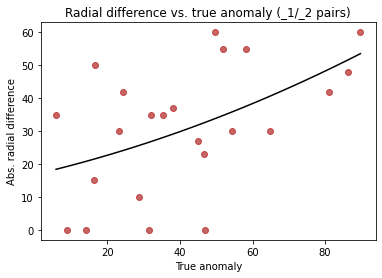

In [66]:
# plot difference between pairs vs. true anomalies

radial_differences = [30,0,35,48,35,10,55,23,55,60,42,42,0,27,37,30,50,30,0,60,0,15,35]

plt.figure()
plt.scatter(true_anomalies, radial_differences, c='firebrick', alpha=0.7)
#trendline
x_vals_to_fit = np.array(true_anomalies)
coeff = np.polyfit(x_vals_to_fit, radial_differences, deg=2)
x_min = x_vals_to_fit.min()
x_max = x_vals_to_fit.max()
x_trend = np.linspace(x_min, x_max, 100)
y_trend = np.polyval(coeff, x_trend)
plt.plot(x_trend, y_trend, c='k', ls='-')
plt.xlabel('True anomaly')
plt.ylabel('Abs. radial difference')
plt.title('Radial difference vs. true anomaly (_1/_2 pairs)')